## Домашнее здание №3 / New Product Forecasting

### Торунова Анастасия / 394

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
%matplotlib inline

/Users/nastya/.virtualenvs/ml/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [129]:
# data = pd.read_csv('blogData_train.csv', header=None)
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [130]:
# Посмотрим на данные
data.head()

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,...,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.00010,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,...,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.00010,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,...,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72
3,0.00010,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,...,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04
4,0.00010,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,...,стандарт,20MAY09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37


### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

In [131]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])]
Categorical_columns = Categorical_columns.append(pd.Index(['LOCATION_ID', 'MODEL_ID']))
Categorical_columns

Index(['MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_NAME', 'MODEL_OS',
       'MODEL_RES_TYPE', 'MODEL_TYPE', 'STORE_BRAND_ABC',
       'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER', 'STORE_DIAG_ABC',
       'STORE_FORMAT', 'STORE_OPEN_DTTM', 'STORE_PRICE_TYPE', 'STORE_REGION',
       'STORE_RES_ABC', 'LOCATION_ID', 'MODEL_ID'],
      dtype='object')

In [132]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>0].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [1654]
Удаляем признаки с номерами: 
                     NoUniqueValues
MODEL_ID                        447
MODEL_NAME                      447
LOCATION_ID                     362
STORE_OPEN_DTTM                 246
STORE_CITY                       36
MODEL_BRAND                      33
STORE_CLUSTER                    23
STORE_PRICE_TYPE                 20
STORE_FORMAT                     10
STORE_REGION                      5
MODEL_OS                          5
STORE_BRAND_ABC                   3
STORE_BUILDING_TYPE               3
MODEL_DIAG_TYPE                   3
STORE_DIAG_ABC                    3
MODEL_RES_TYPE                    3
STORE_RES_ABC                     3
MODEL_TYPE                        2


In [133]:
# Запоминаем те категориальные признаки, с которыми будем далее работать (используется далее)
Categorical_columns_use = Categorical_columns

### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

In [134]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Categorical_columns | data.columns[[1,8]], axis = 1)
num_data.columns

Index(['DEMAND', 'MODEL_COST_AVG', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG',
       'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT',
       'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C', 'STORE_TYPE_SPECTR'],
      dtype='object')

In [135]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [136]:
# Здесь добавьте код по преобразованию числовых признаков

# заполним nan значения из MODEL_COUNT_SALES_DAYS и MODEL_MEAN_SALES средними значениями по колонке:
num_data['MODEL_COUNT_SALES_DAYS'] = num_data['MODEL_COUNT_SALES_DAYS'].fillna(num_data['MODEL_COUNT_SALES_DAYS'].mean())
num_data['MODEL_MEAN_SALES'] = num_data['MODEL_MEAN_SALES'].fillna(num_data['MODEL_COUNT_SALES_DAYS'].mean())
# остальные nan-ы можно дропнуть, потому что их мало.
print(num_data.shape)
print(num_data.dropna().shape)
num_data = num_data.dropna()

(40000, 15)
(39554, 15)


In [137]:
def parse_store_cluster_y(x):
    try:
        return float(x.split('m')[1])
    except:
        return None

In [138]:
def parse_store_cluster_x(x):
    try:
        return float(x.split('m')[0].split('u')[1])
    except:
        return None

На самом деле категориальный признак STORE_CLUSTER содержит 2 вещественных, распарсим их:

In [139]:
num_data['STORE_CLUSTER_X'] = data['STORE_CLUSTER'].apply(parse_store_cluster_x)

In [140]:
num_data['STORE_CLUSTER_Y'] = data['STORE_CLUSTER'].apply(parse_store_cluster_y)
num_data['STORE_CLUSTER_Y'].head()

ID
0    3.0
1    2.0
2    NaN
3    3.0
4    NaN
Name: STORE_CLUSTER_Y, dtype: float64

In [141]:
num_data = num_data.fillna(num_data.mean())

## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [142]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [143]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro', label='test')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo', label='train')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.legend(loc=0)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(predict, testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [17]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [18]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.25447508929
CPU times: user 2.77 ms, sys: 1.27 ms, total: 4.04 ms
Wall time: 2.7 ms
Accuracy: 1.80724933722
CPU times: user 1.54 ms, sys: 130 µs, total: 1.67 ms
Wall time: 1.55 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если требуется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 1, accuracy: 0.955003644469
Count of estimators: 11, accuracy: 1.20895804832
Count of estimators: 21, accuracy: 1.21984434464
Count of estimators: 31, accuracy: 1.22447904485
Count of estimators: 41, accuracy: 1.22829815521
Count of estimators: 51, accuracy: 1.23150887925
Count of estimators: 61, accuracy: 1.22933668439
Count of estimators: 71, accuracy: 1.22775687673
Count of estimators: 81, accuracy: 1.22895262318
Count of estimators: 91, accuracy: 1.23005667315
Count of estimators: 101, accuracy: 1.23015117689
Count of estimators: 111, accuracy: 1.22877119495
Count of estimators: 121, accuracy: 1.22942634611
Count of estimators: 131, accuracy: 1.2286534779
Count of estimators: 141, accuracy: 1.23011779638
CPU times: user 13.8 s, sys: 14.9 s, total: 28.6 s
Wall time: 1min 40s


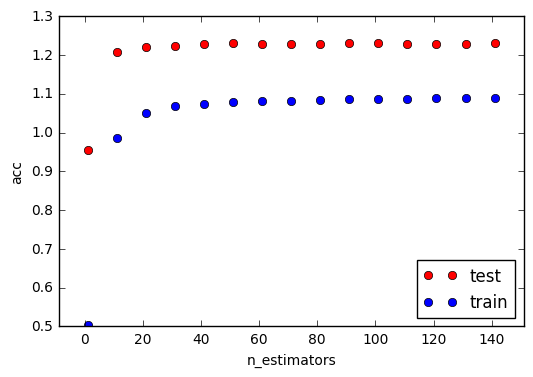

In [20]:
n_est = range(1, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.6, 0.6, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.876069603828
Count of estimators: 11, accuracy: 1.18637115991
Count of estimators: 21, accuracy: 1.22012539344
Count of estimators: 31, accuracy: 1.22365746008
Count of estimators: 41, accuracy: 1.22419952913
Count of estimators: 51, accuracy: 1.2269735672
Count of estimators: 61, accuracy: 1.23071554355
Count of estimators: 71, accuracy: 1.23401554468
Count of estimators: 81, accuracy: 1.23486762004
Count of estimators: 91, accuracy: 1.23389216787
Count of estimators: 101, accuracy: 1.23399712851
Count of estimators: 111, accuracy: 1.2334704554
Count of estimators: 121, accuracy: 1.23310424603
Count of estimators: 131, accuracy: 1.23236905651
Count of estimators: 141, accuracy: 1.23193209699
CPU times: user 2min 9s, sys: 3.46 s, total: 2min 13s
Wall time: 41.9 s


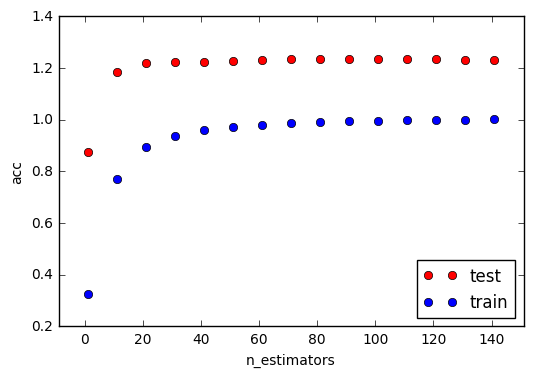

In [21]:
n_est = range(1, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если требуется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.873488674652
Count of estimators: 11, accuracy: 1.15181706166
Count of estimators: 21, accuracy: 1.20563199795
Count of estimators: 31, accuracy: 1.2224486278
Count of estimators: 41, accuracy: 1.23086623563
Count of estimators: 51, accuracy: 1.23365558954
Count of estimators: 61, accuracy: 1.23580523187
Count of estimators: 71, accuracy: 1.23875138573
Count of estimators: 81, accuracy: 1.23793806958
Count of estimators: 91, accuracy: 1.23845366839
Count of estimators: 101, accuracy: 1.23834848031
Count of estimators: 111, accuracy: 1.23728377725
Count of estimators: 121, accuracy: 1.23675146175
Count of estimators: 131, accuracy: 1.23624264632
Count of estimators: 141, accuracy: 1.2354536032
CPU times: user 3min 35s, sys: 6.03 s, total: 3min 41s
Wall time: 1min 11s


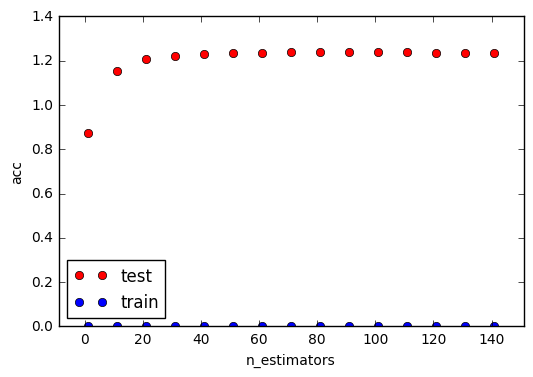

In [22]:
n_est = range(1, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 1.25082293022
Count of estimators: 11, accuracy: 1.23726087457
Count of estimators: 21, accuracy: 1.23284200908
Count of estimators: 31, accuracy: 1.23224950825
Count of estimators: 41, accuracy: 1.23404642269
Count of estimators: 51, accuracy: 1.23590494873
Count of estimators: 61, accuracy: 1.23683022512
Count of estimators: 71, accuracy: 1.23843779034
Count of estimators: 81, accuracy: 1.238539277
Count of estimators: 91, accuracy: 1.23716912434
Count of estimators: 101, accuracy: 1.23740543801
Count of estimators: 111, accuracy: 1.23723626569
Count of estimators: 121, accuracy: 1.2376463363
Count of estimators: 131, accuracy: 1.23818002289
Count of estimators: 141, accuracy: 1.23791472303
CPU times: user 36.6 s, sys: 348 ms, total: 37 s
Wall time: 37.6 s


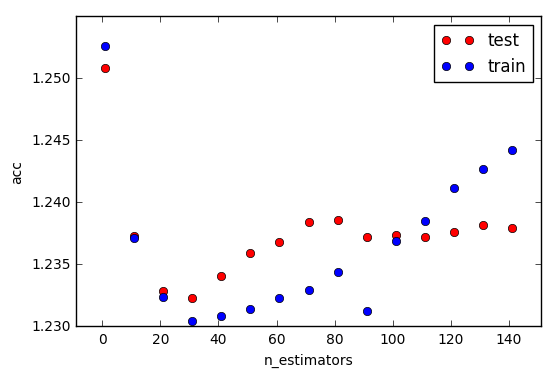

In [23]:
n_est = range(1, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Extremely Randomized Trees переобучаются, остальные методы работают примерно одинаково.
Для всех моделей кроме градиентного бустинга оптимальное количество это 1, а для градиентного бустинга оно около 30.
Скорее всего это потому, что остальные модели складывают свои результаты, увеличивая даже ошибку композиции, а в градиентном бустинге идет исправление ошибок, поэтому ту оптимальное число base estimators > 1.

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [144]:
Categorical_columns = Categorical_columns.delete(Categorical_columns.get_loc('STORE_CLUSTER'))
Categorical_columns = Categorical_columns.delete(Categorical_columns.get_loc('MODEL_NAME'))
Categorical_columns = Categorical_columns.delete(Categorical_columns.get_loc('STORE_PRICE_TYPE'))
Categorical_columns = Categorical_columns.delete(Categorical_columns.get_loc('STORE_FORMAT'))
Categorical_columns = Categorical_columns.delete(Categorical_columns.get_loc('MODEL_ID'))
Categorical_columns

Index(['MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_OS', 'MODEL_RES_TYPE',
       'MODEL_TYPE', 'STORE_BRAND_ABC', 'STORE_BUILDING_TYPE', 'STORE_CITY',
       'STORE_DIAG_ABC', 'STORE_OPEN_DTTM', 'STORE_REGION', 'STORE_RES_ABC',
       'LOCATION_ID'],
      dtype='object')

In [145]:
# Для обучения используются полезные категориальные признаки
Categorical_columns_use = Categorical_columns
bin_data = get_binarized_data(data[Categorical_columns_use], Categorical_columns_use)
print(bin_data.shape)

(40000, 707)


In [146]:
bin_data.isnull().sum().T

MODEL_BRAND: acer            0
MODEL_BRAND: alcatel         0
MODEL_BRAND: apple           0
MODEL_BRAND: archos          0
MODEL_BRAND: ark             0
MODEL_BRAND: asus            0
MODEL_BRAND: bb-mobile       0
MODEL_BRAND: bq              0
MODEL_BRAND: bright&quick    0
MODEL_BRAND: explay          0
MODEL_BRAND: fly             0
MODEL_BRAND: haier           0
MODEL_BRAND: highscreen      0
MODEL_BRAND: htc             0
MODEL_BRAND: huawei          0
MODEL_BRAND: jinga           0
MODEL_BRAND: keneksi         0
MODEL_BRAND: lenovo          0
MODEL_BRAND: lexand          0
MODEL_BRAND: lg              0
MODEL_BRAND: meizu           0
MODEL_BRAND: micromax        0
MODEL_BRAND: microsoft       0
MODEL_BRAND: philips         0
MODEL_BRAND: prestigio       0
MODEL_BRAND: qumo            0
MODEL_BRAND: samsung         0
MODEL_BRAND: sony            0
MODEL_BRAND: stark           0
MODEL_BRAND: texet           0
                            ..
LOCATION_ID: 2022103615      0
LOCATION

##### Исключаем лишние произнаки, заменяем NaN

In [147]:
# Cразу используем датафреймы с нужными признаками -> не нужно удалять то, что уже удаляли до этого
prepared_data = pd.concat([num_data, bin_data], axis=1)

In [148]:
print(prepared_data.shape)
print(prepared_data.dropna().shape)
prepared_data = prepared_data.dropna()

(40000, 724)
(39554, 724)


In [44]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = prepared_data, test_size=0.1,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.824159346016
Count of estimators: 11, accuracy: 1.13466901396
Count of estimators: 21, accuracy: 1.1867836878
Count of estimators: 31, accuracy: 1.1972428849
Count of estimators: 41, accuracy: 1.20493768803
CPU times: user 18.1 s, sys: 4.59 s, total: 22.7 s
Wall time: 4min 36s


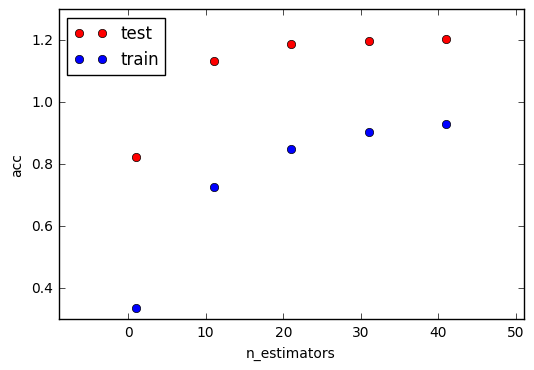

In [48]:
n_est = range(1, 42, 10)
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.96531453344
Count of estimators: 11, accuracy: 1.20776582595
Count of estimators: 21, accuracy: 1.20830986382
Count of estimators: 31, accuracy: 1.21090841043
Count of estimators: 41, accuracy: 1.21054817826
CPU times: user 51.5 s, sys: 1.21 s, total: 52.7 s
Wall time: 17.6 s


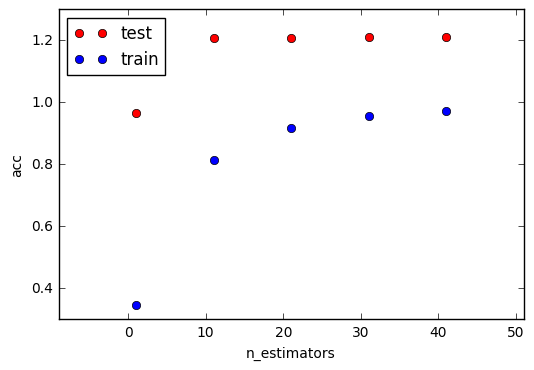

In [49]:
n_est = range(1, 42, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 0.772246765826
Count of estimators: 11, accuracy: 1.06059190168
Count of estimators: 21, accuracy: 1.11338486481
Count of estimators: 31, accuracy: 1.13797254856
Count of estimators: 41, accuracy: 1.15411531288
CPU times: user 28min 15s, sys: 8.58 s, total: 28min 24s
Wall time: 8min 44s


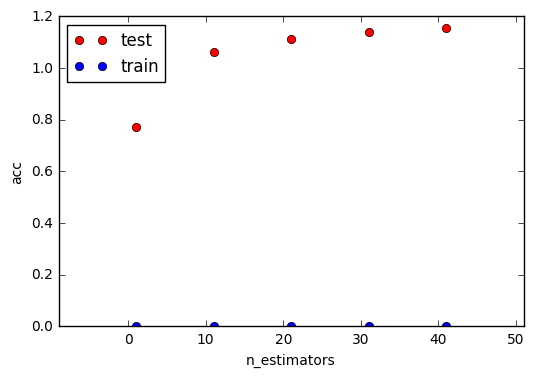

In [50]:
n_est = range(1, 42, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 1, accuracy: 1.25130017873
Count of estimators: 11, accuracy: 1.2366721279
Count of estimators: 21, accuracy: 1.23074983015
Count of estimators: 31, accuracy: 1.22940321427
Count of estimators: 41, accuracy: 1.22904670841
CPU times: user 2min 25s, sys: 1.06 s, total: 2min 26s
Wall time: 2min 26s


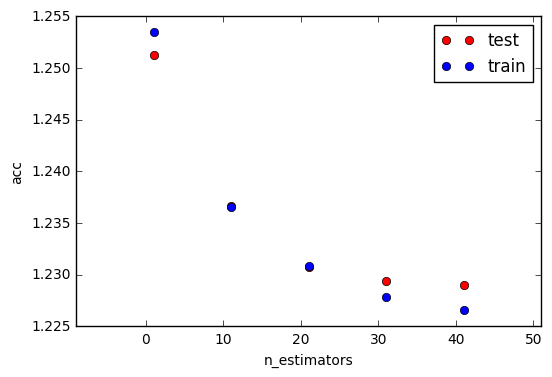

In [51]:
n_est = range(1, 42, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**
Результаты полностью аналогичны результатам только на вещественных признаках.
Из-за добавления дополнительных признаков результаты лучше.

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [57]:
model = LinearRegression()
model = model.fit(trainX, trainY)
Y_pred = model.predict(testX)
print('Linear Regression result: {}'.format(smape_loss_func(Y_pred, testY)))

/Users/nastya/.virtualenvs/ml/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Linear Regression result: 1.3587721049527186


In [60]:
model = DecisionTreeRegressor()
model = model.fit(trainX, trainY)
Y_pred = model.predict(testX)
print('Decision Tree result: {}'.format(smape_loss_func(Y_pred, testY)))

Decision Tree result: 0.7813987705724602


## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [150]:
test = pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID')

In [151]:
# Вспомним, какие вещественные столбцы были в трейновой выборке
num_data.columns

Index(['DEMAND', 'MODEL_COST_AVG', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG',
       'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT',
       'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C', 'STORE_TYPE_SPECTR',
       'STORE_CLUSTER_X', 'STORE_CLUSTER_Y'],
      dtype='object')

In [152]:
# Вспомним, какие были категориальные
Categorical_columns_use

Index(['MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_OS', 'MODEL_RES_TYPE',
       'MODEL_TYPE', 'STORE_BRAND_ABC', 'STORE_BUILDING_TYPE', 'STORE_CITY',
       'STORE_DIAG_ABC', 'STORE_OPEN_DTTM', 'STORE_REGION', 'STORE_RES_ABC',
       'LOCATION_ID'],
      dtype='object')

In [153]:
# добавим те вещественные признаки, которые уже есть в тестовой выборке
test_num_data = test[num_data.columns[1:-2]]

In [154]:
test_num_data.columns

Index(['MODEL_COST_AVG', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG',
       'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT',
       'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C', 'STORE_TYPE_SPECTR'],
      dtype='object')

In [155]:
test_num_data.isnull().sum().T

MODEL_COST_AVG               0
MODEL_COUNT_SALES_DAYS    5391
MODEL_DIAG                  55
MODEL_HEIGHT                55
MODEL_MEAN_SALES          5391
MODEL_WIDTH                 55
STORE_ASSORTMENT            83
STORE_BRAND_SPECTR          83
STORE_DIAG_SPECTR          138
STORE_RES_SPECTR           138
STORE_TYPE_A                 0
STORE_TYPE_B                 0
STORE_TYPE_C                 0
STORE_TYPE_SPECTR            0
dtype: int64

In [156]:
# Распарсим STORE_CLUSTER в тесте:
test_num_data['STORE_CLUSTER_X'] = test['STORE_CLUSTER'].apply(parse_store_cluster_x)
test_num_data['STORE_CLUSTER_Y'] = test['STORE_CLUSTER'].apply(parse_store_cluster_y)

/Users/nastya/.virtualenvs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/nastya/.virtualenvs/ml/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [157]:
# заменим nan-ы средними значениями для всех столбцов:
test_num_data = test_num_data.fillna(num_data.mean())

In [158]:
# Обрабатываем категориальные признаки:
test_bin_data = get_binarized_data(test[Categorical_columns_use], Categorical_columns_use)

In [159]:
# соединяем все полезные признаки в 1 датафрейм
prepared_test_data = pd.concat([test_num_data, test_bin_data], axis=1)

In [161]:
print(prepared_test_data.shape)
print(prepared_test_data.dropna().shape)
# prepared_test_data = prepared_test_data.fillna(prepared_test_data.mean())

(11296, 717)
(11296, 717)


In [162]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0 (это просто некоторые модели телефонов)
add_columns = prepared_data.columns[1:].difference(prepared_test_data.columns)

prepared_test_data = pd.merge(prepared_test_data, prepared_data.ix[prepared_test_data.index][add_columns], how='inner', left_index=True, right_index=True)
prepared_test_data[add_columns]=0

In [163]:
prepared_data.columns[1:].difference(prepared_test_data.columns)

Index([], dtype='object')

In [164]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = prepared_data, test_size=0,  y_column_name='DEMAND')

In [165]:
trainX.shape

(39554, 723)

In [166]:
# Обучаем финальный алгоритм
final_regressor = DecisionTreeRegressor()
final_regressor.fit(trainX, trainY)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [167]:
print(prepared_test_data.shape)
print(prepared_test_data.dropna().shape)

(11296, 723)
(11296, 723)


In [168]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(prepared_test_data))

In [178]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./data/submission_gbdt.csv', sep = ',', index = True)